In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_auc_score
import joblib

In [19]:
from google.colab import drive
drive.mount('/content/drive')
provider_df = pd.read_csv('/content/drive/MyDrive/provider_features.csv')

X = provider_df.drop(columns=["Provider","target"])
y = provider_df["target"]
provider_df.shape
provider_df['target'].value_counts()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,count
target,
0,3025
1,478


In [20]:
drive_path = '/content/drive/MyDrive/trained_models/'
scaler = joblib.load(drive_path + 'scaler.joblib')
model_files = {
"Decision Tree": drive_path + 'decision_tree_model.joblib',
"Random Forest": drive_path + 'random_forest_model.joblib',
"Gradient Boosting": drive_path + 'gradient_boosting_model.joblib',
"SVM": drive_path + 'svm_model.joblib'
}

In [21]:
fitted_models = {name: joblib.load(path) for name, path in model_files.items()}

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)
X_test_scaled = scaler.transform(X_test)

In [22]:
for name, model in fitted_models.items():
    print(f"\n===== {name} =====")
    if name == "SVM":
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:,1]
    else:
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:,1]

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))


===== Decision Tree =====
Confusion Matrix:
[[542  63]
 [ 58  38]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9033    0.8959    0.8996       605
           1     0.3762    0.3958    0.3858        96

    accuracy                         0.8274       701
   macro avg     0.6398    0.6459    0.6427       701
weighted avg     0.8311    0.8274    0.8292       701


===== Random Forest =====
Confusion Matrix:
[[589  16]
 [ 56  40]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9132    0.9736    0.9424       605
           1     0.7143    0.4167    0.5263        96

    accuracy                         0.8973       701
   macro avg     0.8137    0.6951    0.7344       701
weighted avg     0.8859    0.8973    0.8854       701


===== Gradient Boosting =====
Confusion Matrix:
[[591  14]
 [ 55  41]]

Classification Report:
              precision    recall  f1-score   support

           

In [23]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")

ROC-AUC: 0.8714, PR-AUC: 0.4880


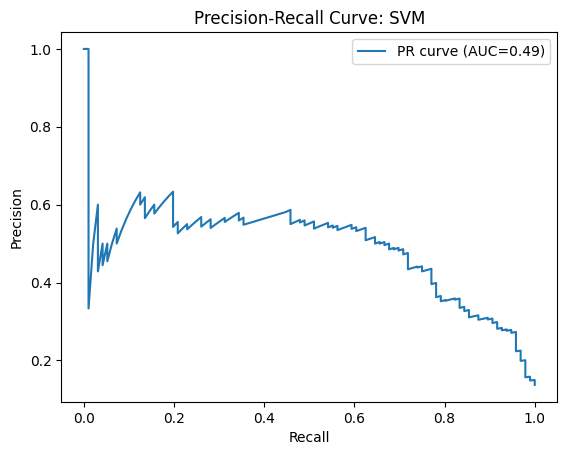

In [24]:
plt.figure()
plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve: {name}')
plt.legend()
plt.show()

In [26]:
tree_models = ["Decision Tree", "Random Forest", "Gradient Boosting"]
features = X.columns

In [27]:
for name in tree_models:
    model = fitted_models[name]
    importances = model.feature_importances_
    imp_df = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values(by="Importance", ascending=False)

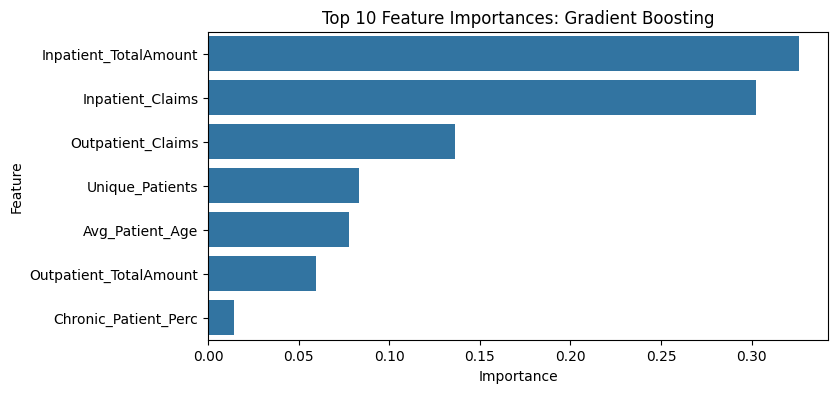

In [28]:
plt.figure(figsize=(8,4))
sns.barplot(x="Importance", y="Feature", data=imp_df.head(10))
plt.title(f"Top 10 Feature Importances: {name}")
plt.show()

In [29]:
# ----- ERROR ANALYSIS -----

import pandas as pd

# Identify model to analyze (best model)
best_model = fitted_models["Gradient Boosting"]

# Get predictions for error analysis
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Attach provider IDs to X_test
X_test_reset = X_test.reset_index(drop=True)

# Reconstruct provider column by merging with original dataset
provider_ids = provider_df.loc[X_test_reset.index, "Provider"].values

# Build a results dataframe
results = X_test_reset.copy()
results["Provider"] = provider_ids
results["y_true"] = y_test.values
results["y_pred"] = y_pred
results["y_prob"] = y_prob

# Extract 2–3 false positives and false negatives
false_positives = results[(results["y_true"] == 0) & (results["y_pred"] == 1)].head(3)
false_negatives = results[(results["y_true"] == 1) & (results["y_pred"] == 0)].head(3)

print("===== FALSE POSITIVES (Legitimate providers flagged as fraud) =====")
display(false_positives)

print("\n===== FALSE NEGATIVES (Fraud providers missed) =====")
display(false_negatives)


===== FALSE POSITIVES (Legitimate providers flagged as fraud) =====


,Inpatient_Claims,Inpatient_TotalAmount,Outpatient_Claims,Outpatient_TotalAmount,Avg_Patient_Age,Unique_Patients,Chronic_Patient_Perc,Provider,y_true,y_pred,y_prob
8,12.0,165000.0,21.0,3650.0,77.032419,28,96.969697,PRV51013,0,1,0.960732
24,3.0,28000.0,5.0,430.0,76.208761,5,100.000000,PRV51038,0,1,0.507983
110,7.0,92000.0,5.0,650.0,72.075291,12,100.000000,PRV51189,0,1,0.585931



===== FALSE NEGATIVES (Fraud providers missed) =====


,Inpatient_Claims,Inpatient_TotalAmount,Outpatient_Claims,Outpatient_TotalAmount,Avg_Patient_Age,Unique_Patients,Chronic_Patient_Perc,Provider,y_true,y_pred,y_prob
4,3.0,75000.0,2.0,30.0,80.633539,5,80.0,PRV51007,1,0,0.319663
14,2.0,37000.0,5.0,480.0,75.439523,7,100.0,PRV51024,1,0,0.378203
44,1.0,10200.0,0.0,0.0,88.416153,1,100.0,PRV51067,1,0,0.323625
